In [1]:
#@title Black Box_(install libraries)
%%capture
!pip install pingouin
!pip install autoreject
!pip install mne
!pip install mne_bids
!pip install mne_icalabel
!pip install pyprep
!pip install onnxruntime
!pip install python-picard
!pip install ipywidgets
!pip install IPhyton
!apt-get -qq update
!apt-get -qq install tree

Hola!

<br>

Este tutorial tendrá como objetivo enseñar un flujo de análisis para Potenciales Relacionados a Eventos y Time Frequency Analysis.

<br>

Los datos que utilizaremos para contextualizar los cálculos son del paper:


> Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.

<br>

Obtenidos mediante el <a href="https://osf.io/6gjkz/files"
  target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
  repositorio
  </a> abierto en el cual se ha publicado. Parte del flujo de pre procesamiento intentará replicar las decisiones que tomaron los investigadores mediante las herramientas disponibles en Python. Sin embargo, en algún momento diferiremos del original por motivos de simplificación para la demostración.

<br>

A grandes rasgos, el procesamiento de EEG tiene este flujo.



<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_01.png"
       alt="montaje"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Flujo general.</figcaption>
</figure>


<br>

En este tutorial nos centraremos en la etapa más concentrada en el pre procesamiento de datos.

<br>

A lo largo del tutorial, podremos encontrar bloques de código con el texto "Ｂｌａｃｋ　Ｂｏｘ". Estos bloques de código sólo están pensados para ser ejecutados. Más allá de esbozar una idea general o conceptual, no explicaremos lo que sucede dentro de las cajas negras, pero ejecutarlas es necesario para poder seguir con la experiencia.

In [2]:
#@title Example BlackBox

import ipywidgets


# Variables
PASSWORD_1 = "ciencia"
PASSWORD_2 = "curiosidad"
IMG_URL_1 = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Black_box_diagram.svg/1920px-Black_box_diagram.svg.png"
IMG_URL_2 = "https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/06_ai.png"
output=ipywidgets.Output()

# 1st
pwd1 = ipywidgets.Password(
    description='Password：',
    placeholder="¿Qué abre la caja negra?",
    continuous_update=True,
    layout=ipywidgets.Layout(width='300px')
    )


# 2nd
pwd2 = ipywidgets.Password(
    description='Ｐａｓｓｗｏｒｄ：',
    placeholder="",
    continuous_update=True,
    layout=ipywidgets.Layout(width='300px')
    )

pwd2.layout.display = "none"

# img
img = ipywidgets.HTML(value=f'<img src="{IMG_URL_1}" width="600">')
img.layout.display = "none"

# manejo del primer password
def on_pwd1(change):
    if change['name'] == 'value' and change['new'] == PASSWORD_1:
        with output:
           output.clear_output()
           print("Ｗｈａｔ ｒｅａｌｌｙ　ｏｐｅｎｓ　ｔｈｅ　Ｂｌａｃｋ　Ｂｏｘ？")
        img.layout.display = "block"
        pwd2.layout.display = "block"
        pwd1.layout.display = "none"
        pwd1.unobserve(on_pwd1, names="value")

# manejo del segundo password
def on_pwd2(change):
    if change['name'] == 'value' and change['new'] == PASSWORD_2:
        with output:
          output.clear_output()
          print("")
        img.value = f'<img src="{IMG_URL_2}" width="600">'
        pwd2.unobserve(on_pwd2, names="value")
        pwd2.layout.display = "none"

# activate observs
pwd1.observe(on_pwd1, names="value")
pwd2.observe(on_pwd2, names="value")


display(pwd1, img, pwd2, output)



Password(description='Password：', layout=Layout(width='300px'), placeholder='¿Qué abre la caja negra?')

HTML(value='<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Black_box_diagram.svg/1920px-B…

Password(description='Ｐａｓｓｗｏｒｄ：', layout=Layout(display='none', width='300px'), placeholder='')

Output()

In [3]:
#@title Import modules

%%capture
import autoreject
import ipywidgets
import matplotlib.pyplot as plt
import mne
import mne_bids
import mne_icalabel
import numpy as np
import os
import pandas as pd
import pyprep


| Paquete                | Descripción                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| autoreject           | Librería para la detección automática de artefactos en los datos de EEG mediante el algoritmo de AutoReject. |
| ipywidgets                    | Widgets para algunas de nuestras ＢｌａｃｋＢｏｘ. |
| matplotlib                    | Crear visualizaciones estáticas, animadas e interactivas. Librería fundamental de otras que también generan gráficos. |
| mne                    | Librería para el análisis de datos de EEG, MEG y otros tipos de datos para neurociencia computacional. |
| mne-bids               | Extensión de MNE para manejar datos en formato BIDS. |
| mne-icalabel           | Un algoritmo entrenado para etiquetar automáticamente componentes encontrados mediante un Independent Component Analysis (ICA). |
| numpy           | Librería base para trabajar matemáticamente con arrays de datos. Es la base de pandas y muchas otras librerías que usamos. |
| os           | Módulo de Python para interactuar con las rutas del sistema operativo. |
| pandas           | Librería fundamental para la computación e interacción de datos estructurados (matrices). |
| pyprep           | Permite utilizar el pipeline PREP en Python para rechazar electrodos y mejorar la señal EEG. |

In [4]:
#@title Black Box_(download data in BIDS format)
#%%capture
!wget "https://drive.usercontent.google.com/download?id=1wwNiWnMGSvVJ25FnVXJ3t7M58mSgWwgB&export=download&confirm" -O BIDS.zip
!unzip -o BIDS.zip

--2025-11-08 02:19:49--  https://drive.usercontent.google.com/download?id=1wwNiWnMGSvVJ25FnVXJ3t7M58mSgWwgB&export=download&confirm
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592796496 (565M) [application/octet-stream]
Saving to: ‘BIDS.zip’

BIDS.zip            100%[===================>] 565.33M  76.5MB/s    in 7.5s    

2025-11-08 02:19:58 (75.1 MB/s) - ‘BIDS.zip’ saved [592796496/592796496]

Archive:  BIDS.zip
   creating: bids/
   creating: bids/exp/
   creating: bids/exp/sub-02/
   creating: bids/exp/sub-02/eeg/
  inflating: bids/exp/sub-02/eeg/sub-02_task-default_eeg.vhdr  
  inflating: bids/exp/sub-02/eeg/sub-02_task-default_channels.tsv  
  inflating: bids/exp/sub-02/eeg/sub-02_task-default_eeg.eeg  
  inflating: bids/exp/sub-02/eeg/sub-02_task-defa

# ¿Qué es MNE Python?

MNE es una librería que brinda herramientas para analizar datos neuofisiológicos.  

Es una herramienta gratuita, pues se construye dentro del marco de la **Open Science**

Los datos que MNE permite analizar con sus funciones son: MEG, EEG, fMRI, sEEG, ECoG, NIRS, eyetracking; entre muchos otros.

Desde que ejecutamos el módulo para importar los datos, ya nos podemos percatar de que tiene una palabra extraña: **"BIDS"**.  

Estas siglas pertenecen a las palabras: **Brain Imaging Data Structure.**  
<br><br>
<center>

> <em>¿Profe... por qué tener un estándar para organizar data?  
¿No puedo analizarla como quiera?</em>  
  

</center>
<br><br>

En realidad, sí. Estamos en lo cierto en pensar que podemos organizar **nuestra data** como queramos, hacer cálculos y llegar a conclusiones sin ninguna dificultad. Sin embargo

<br><br>

<center>


---

<br>

¿Cómo podemos evaluar la certeza de algo que **solamente nosotros** sabemos?

<br>

---


</center>
<br><br>



Pues aquí es donde entra el BIDS.  
<br>
Dentro de la ciencia abierta, cualquiera **debe** tener el derecho de cuestionar; no solamente por una razón comunitaria, sino intelectual, ya que nuestros hallazgos sólo pueden pulir su validez mediante el cuestionamiento constante.   
<br>
Así, compartir los datos de manera menos críptica y más clara para hacer ciencia, lleva a que tengamos que desarrollar una convención para su organización.
<br>  
Más allá de la programación, como la estructura es una iniciativa en el marco la ciencia abierta, existen también distintas <a href="https://brainlife.io/docs/using_ezBIDS/"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      herramientas</a> más user-friendly para quien empieza a organizar los datos en formato BIDS.

<br>  

BIDS es la convención que usan bases de datos públicas como:  


<a href="https://openneuro.org/"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      **Open Neuro**
  </a>


<a href="https://www.neuroinfo.org/gsp"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      **Brain Genomics Superstruct Project**
  </a>

<a href="https://www.ebrains.eu/"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      **Ebrains**
  </a>

<a href="https://brainlife.io/about/"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      **Brainlife**
  </a>


Y más.

<h1>Base de datos normal Vs BIDS</h1>
<figure style="text-align:center; margin: 1.25rem 0;">
  <img src="https://bids.neuroimaging.io/assets/img/dicom-reorganization-transparent-white_1000x477.png"
       alt="Dataset EEG-BIDS"
       style="display:block; margin:0 auto; max-width:100%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Reorganización DICOM → BIDS.</figcaption>
</figure>

<h1>¿Qué hay dentro de cada archivo?</h1>
<figure style="text-align:center; margin: 1.25rem 0;">
  <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-019-0104-8/MediaObjects/41597_2019_104_Fig1_HTML.png"
       alt="Dataset EEG-BIDS"
       style="display:block; margin:0 auto; max-width:100%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Estructura interna de un dataset BIDS.</figcaption>
</figure>





Incluso ¡Podríamos intentar descargar una base de datos BIDS con sólo un click!
```
!pip install openneuro-py
on.download(
    dataset='ds004284', # OpenNeuro Accession Number
    target_dir='/content/data',  # Carpeta donde se guardará el dataset
    include=['sub-104/']  # Solo incluir los participantes sub-104
)
```

Pero esto es una caja negra para otra historia...

# Nuestros datos BIDS.


Como mencionamos anteriormente, los datos que hemos descargado son datos formateados en BIDS, pertenecientes al paper:

> Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.





Cuya base de datos completa se encuentra disponible en   <a href="https://osf.io/6gjkz/files"
  target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
  Open Science Framework
  </a>  


In [5]:
!tree "bids" -L 4

bids
└── exp
    ├── dataset_description.json
    ├── participants.json
    ├── participants.tsv
    ├── README
    ├── sub-01
    │   ├── eeg
    │   │   ├── sub-01_task-default_channels.tsv
    │   │   ├── sub-01_task-default_eeg.eeg
    │   │   ├── sub-01_task-default_eeg.json
    │   │   ├── sub-01_task-default_eeg.vhdr
    │   │   ├── sub-01_task-default_eeg.vmrk
    │   │   ├── sub-01_task-default_events.json
    │   │   └── sub-01_task-default_events.tsv
    │   └── sub-01_scans.tsv
    ├── sub-02
    │   ├── eeg
    │   │   ├── sub-02_task-default_channels.tsv
    │   │   ├── sub-02_task-default_eeg.eeg
    │   │   ├── sub-02_task-default_eeg.json
    │   │   ├── sub-02_task-default_eeg.vhdr
    │   │   ├── sub-02_task-default_eeg.vmrk
    │   │   ├── sub-02_task-default_events.json
    │   │   └── sub-02_task-default_events.tsv
    │   └── sub-02_scans.tsv
    ├── sub-04
    │   ├── eeg
    │   │   ├── sub-04_task-default_channels.tsv
    │   │   ├── sub-04_task-default_eeg.ee

Para leer todos estos archivos, utilizaremos en conjunto las librerías de "os" (para navegar entre directorios) y MNE-BIDS.  

En específico, invocaremos la función ```mne_bids.find_matching_paths```, con palabras que le indicarán qué información leer/revisar.  

<br>

Las dos funciones de "os" nos servirán para armar la ruta hacia nuestro experimento.

<br>

<table>
  <tr><th colspan="2" align="left">Función: os.getcwd
  <a href="https://docs.python.org/3/library/os.html#os.getcwd"
  target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
  [docs]
  </a>  
  
  </th></tr>
  <td>
  Obtiene y retorna la dirección del directorio en el se ejecuta la función. Básicamente, nos dice la dirección (path) en la que nos encontramos.
  </td>
</table>

<br>


<table>
  <tr><th colspan="2" align="left">Función: os.path.join
  <a href="https://docs.python.org/3/library/os.path.html#os.path.join"
  target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
  [docs]
  </a>
</th></tr>
  <td>
  Sirve para unir rutas en formato de string. Tendremos que unir la dirección del directorio actual más "bids/exp".
  </td>
  </tr>
</table>


<br>

Sin embargo, lo que realmente tendrá poder aquí para escanear todos los archivos eeg en formato BIDS posibles, es ```mne_bids.find_matching_paths```:


<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne_bids.find_matching_paths</strong>
  
  </strong>
      <a href="https://mne.tools/mne-bids/stable/generated/mne_bids.find_matching_paths.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>root</td><td>Lugar (dirección del directorio) desde el que queremos que se busquen rutas BIDS</td></tr>
  <tr><td>subjects</td><td>El "ID" del sujeto. Es numérico (si es "sub-24", solo se coloca "24"). Recibe valores singulares o listas de varios valores</td></tr>
  <tr><td>tasks</td><td>Tarea experimental. Por ejemplo: 'oddball', 'SART'.</td></tr>
  <tr><td>datatypes</td><td>Tipos de datos que guarda el formato BIDS. Por ejemplo: 'anat', 'func', 'eeg', 'meg', 'ieeg'. </td></tr>
  <tr><td>extensions</td><td>Extensión de los archivos que queremos que busque. Por ejemplo: '.edf', '.vhdr'. Varía según el aparato que se usó.</td></tr>
  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Lista de objetos BIDSPath. Estos objetos contienen la ruta al archivo eeg y además información adicional acerca del id del sujeto, task, etc.
  </td>
</table>


In [6]:
paths = mne_bids.find_matching_paths(
                            root=os.path.join(os.getcwd(), 'bids/exp'), #La carpeta a revisar
                            subjects=['01', '02', '04', '05', '23'], # ¿Qué sujetos queremos leer?
                            #tasks=, # No utilizaremos este argumento. Por default, al ignorarlo señala todas las task del experimento.
                            datatypes='eeg', #¿Qué tipo de dato hay que leer? BIDS se utiliza también para meg, fmri. Hay que especificar.
                            extensions='.vhdr' # este archivo apunta a los demás (Vision HeaDeR)
                            )
print(f"Al final, creamos una lista de objetos 'BIDSPath', es decir, rutas de BIDS:\n{paths}")

Al final, creamos una lista de objetos 'BIDSPath', es decir, rutas de BIDS:
[BIDSPath(
root: /content/bids/exp
datatype: eeg
basename: sub-01_task-default_eeg.vhdr), BIDSPath(
root: /content/bids/exp
datatype: eeg
basename: sub-02_task-default_eeg.vhdr), BIDSPath(
root: /content/bids/exp
datatype: eeg
basename: sub-04_task-default_eeg.vhdr), BIDSPath(
root: /content/bids/exp
datatype: eeg
basename: sub-05_task-default_eeg.vhdr), BIDSPath(
root: /content/bids/exp
datatype: eeg
basename: sub-23_task-default_eeg.vhdr)]


<h2>Leer varios archivos en bucle</h2>

Bien, ya tenemos las rutas en las cuales se encuentran los archivos, ahora sólo falta leerlos mediante la función de MNE-BIDS. Para eso haremos una iteración en el objeto <code>paths</code>, recuperarmos los BIDSPath y se leerán con la función:
``` mne_bids.read_raw_bids ```

<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne_bids.read_raw_bids</strong>
  
  </strong>
      <a href="https://mne.tools/mne-bids/stable/generated/mne_bids.read_raw_bids.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>bids_path</td><td>Objeto BIDSPath, que contiene la ruta (path) e información adicional</td></tr>
<tr><td>extra_params</td><td>Parámetros extra de la función que internamente se usa para leer los archivos:      <a href="https://mne.tools/stable/generated/mne.io.read_raw.html"
      target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
    mne.io.read_raw</a>. Los parámetros adicionales se tendrán que pasar en forma de diccionario. Nosotros usaremos {'preload':True}
</td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto leído con MNE-Python de tipo: <a href="https://mne.tools/stable/generated/mne.io.Raw.html"
      target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
    mne.io.raw</a>. Se le denomina objeto 'raw', porque no ha recibido ningún cambio de pre procesado. Es la señal de EEG.
</td>
</table>

<br>

Todos los objetos leídos los almacenaremos en un diccionario llamado <code>original_eeg</code>, el cual crearemos primero. Las keys del diccionario serán los id de los participantes, y los values serán los objetos EEG/'Raw'

In [7]:
##Iteramos por cada elemento en la lista (path) para leer el archivo
original_eeg ={}
for path in paths:
    raw = mne_bids.read_raw_bids(path, extra_params= {
        'preload': True #este parametro nos permite leer toda la data en la memoria RAM. Necesario para hacer cálculos de filtrado.
        })
    sub = path.subject # obtenemos la información del sujeto. Este es un método del objeto BIDSPath. Se obtiene como número de ID.
    original_eeg[sub] = raw  #guardaremos el archivo eeg en un diccionario, que tiene como clave el sujeto y como valor el archivo eeg

Extracting parameters from /content/bids/exp/sub-01/eeg/sub-01_task-default_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1185699  =      0.000 ...  4742.796 secs...
Reading events from /content/bids/exp/sub-01/eeg/sub-01_task-default_events.tsv.
Reading channel info from /content/bids/exp/sub-01/eeg/sub-01_task-default_channels.tsv.
Extracting parameters from /content/bids/exp/sub-02/eeg/sub-02_task-default_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1112414  =      0.000 ...  4449.656 secs...
Reading events from /content/bids/exp/sub-02/eeg/sub-02_task-default_events.tsv.
Reading channel info from /content/bids/exp/sub-02/eeg/sub-02_task-default_channels.tsv.
Extracting parameters from /content/bids/exp/sub-04/eeg/sub-04_task-default_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1000089  =      0.000 ...  4000.356 secs...
Reading events from /content/bids/exp/sub-04/eeg/sub-04_task-default_events.tsv.
Reading channel info from /content/bids

In [8]:
display(original_eeg)

{'01': <RawBrainVision | sub-01_task-default_eeg.eeg, 32 x 1185700 (4742.8 s), ~289.5 MiB, data loaded>,
 '02': <RawBrainVision | sub-02_task-default_eeg.eeg, 32 x 1112415 (4449.7 s), ~271.6 MiB, data loaded>,
 '04': <RawBrainVision | sub-04_task-default_eeg.eeg, 32 x 1000090 (4000.4 s), ~244.2 MiB, data loaded>,
 '05': <RawBrainVision | sub-05_task-default_eeg.eeg, 32 x 1002835 (4011.3 s), ~244.9 MiB, data loaded>,
 '23': <RawBrainVision | sub-23_task-default_eeg.eeg, 32 x 990965 (3963.9 s), ~242.0 MiB, data loaded>}

In [9]:
display(original_eeg['01'])

<RawBrainVision | sub-01_task-default_eeg.eeg, 32 x 1185700 (4742.8 s), ~289.5 MiB, data loaded>

¡Bien!

<br>

Ya tenemos los archivos EEG. El que estén en BIDS nos facilitó bastante saber dónde encontrar cada participante y su archivo asociado. Pudimos leer 5 participantes en una sola llamada.

<br>

Ahora, podríamos quedarnos explorando por largo rato todas las posibilidades que existen a este nivel, aún sin pre procesar.  

<br>

Quizá la más importante, antes de empezar a limpiar la data, es elegir un mapa de ubicación para los electrodos.  

<br>

<center>

 <em>

> ¿Cómo así profe? ¿Puedo elegir dónde se colocan los electrodos? ¿Eso no dependía del experimento?

 </em>


</center>

<br>

En realidad, sí. El experimento es algo que ya sucedió, pero a nivel de datos, todavía MNE no sabe qué ubicación espacial (montaje) tuvieron, pues hay tantos tipos de electroencefalogramas que existen distintos mapas.  

<br>

Para nuestra suerte, los científicos precedentes ya definieron convenciones por nosotros. El montaje "1020" es el que fue elegido en el paper en cuestión.

<figure style="text-align:center; margin: 1.25rem 0;background:#fff;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/70/21_electrodes_of_International_10-20_system_for_EEG.svg"
       alt="montaje"
       style="display:block; margin:0 auto; max-width:100%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Montaje 1020.</figcaption>
</figure>

Utilizaremos entonces las funciones de MNE para obtener la información del montaje 1020 y aplicarla a nuestros electrodos. Primero, podemos empezar viendo qué montajes disponibles tiene MNE para ser aplicados. Para ello, se utilizará la función <code>mne.channels.get_builtin_montages</code>

<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.channels.get_builtin_montages</strong>
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.channels.get_builtin_montages.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>descriptions</td><td>False o True. Describe o no la lista de montajes que retorna</td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Lista de montajes que se pueden aplicar en MNE Python. Son únicamente nombres o strings de texto.
</table>

In [10]:
mne.channels.get_builtin_montages(descriptions=True)

[('standard_1005',
  'Electrodes are named and positioned according to the international 10-05 system (343+3 locations)'),
 ('standard_1020',
  'Electrodes are named and positioned according to the international 10-20 system (94+3 locations)'),
 ('standard_alphabetic',
  'Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)'),
 ('standard_postfixed',
  'Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)'),
 ('standard_prefixed',
  'Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)'),
 ('standard_primed',
  "Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)"),
 ('biosemi16', 'BioSemi cap with 16 electrodes (16+3 locations)'),
 ('biosemi32', 'BioSemi cap with 32 electrodes (32+3 locations)'),
 ('biosemi64', 'BioSemi cap w

¡Genial!  

<br>

Sabemos que el montaje <code>'standart_1020'</code> está disponible. Los montajes en MNE son objetos que en esencia son imágenes, pero que tienen atributos para ser manipulados y así agregar o quitar canales. Entonces, para crear este tipo de objeto, tendremos que utilizar la función <code>mne.channels.make_standard_montage</code> y guardar su output.

<br>


<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.channels.make_standard_montage</strong>
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.channels.make_standard_montage.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>kind</td><td>Tipo de montaje que queremos crear. En este caso "standard_1020"</td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto tipo       <a href="https://mne.tools/stable/generated/mne.channels.DigMontage.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      DigMontage</a>. Es una figura con atributos.
</table>

<br>

Al crear y guardar el objeto del montaje, lo que faltaría sería aplicarlo. Para ello iteraremos entre cada objeto eeg/'raw' que se acaba de leer y guardar en el diccionario. Un método de esos objetos es `.set_montage`, el cual nos permitirá aplicar el montaje que hemos creado. Invocaremos entonces al objeto con su método.


<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.set_montage <br><br>
  Objeto mne.io.Raw</strong>
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>montage</td><td>El nombre del montaje que queremos aplicar: "standard_1020"</td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto tipo  
<a href="https://mne.tools/stable/generated/mne.io.Raw.html"
    target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
  mne.io.raw</a>. Es el objeto EEG ya con montaje aplicado.
</table>

In [11]:
#Recuperamos el objeto que contiene el montaje de la librería MNE.
montage = mne.channels.make_standard_montage("standard_1020")
# Lo aplicamos mediante un for loop a cada objeto EEG.

for sub, eeg in original_eeg.items():
  eeg=eeg.copy() #para no cambiar el objeto mismo mientras iteramos en él.
  eeg.set_montage(montage) #aplicamos el montaje.
  original_eeg[sub]=eeg

In [12]:
display(original_eeg['01'])

<RawBrainVision | sub-01_task-default_eeg.eeg, 32 x 1185700 (4742.8 s), ~289.5 MiB, data loaded>

Mediante el método `plot_sensors`, podemos tener una idea de cómo se ubican los electrodos en este montaje. Intenemos plotearlo en 2D y 3D, porque...  

¿Por qué no?

<br>


<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_sensors <br><br>
  Objeto mne.io.Raw</strong>
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.plot_sensors"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>kind</td><td>Utilizaremos "topomap" para la visión 2D y luego "3d" en la segunda aplicación. </td></tr>
<tr><td>show_names</td><td>True o False. Para mostrar o no el nombre de los electrodos. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Figura de montaje creada con matplotlib.
</table>

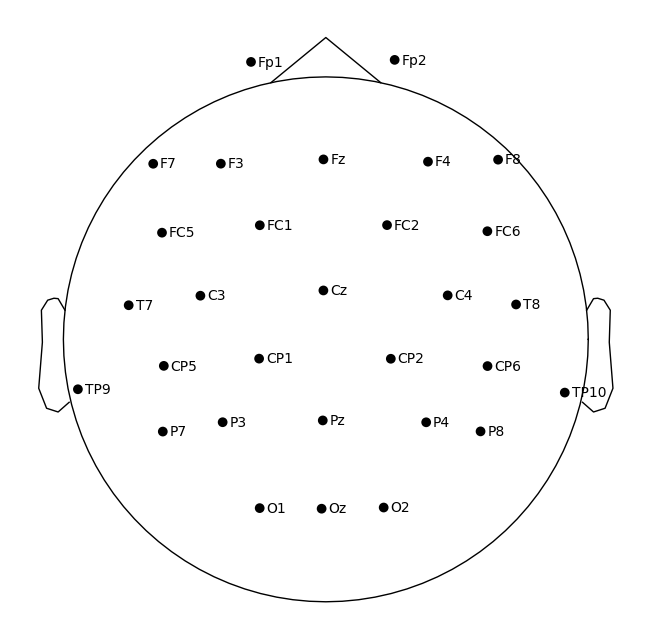

In [13]:
graph1=original_eeg['01'].plot_sensors(kind='topomap', show_names=True)

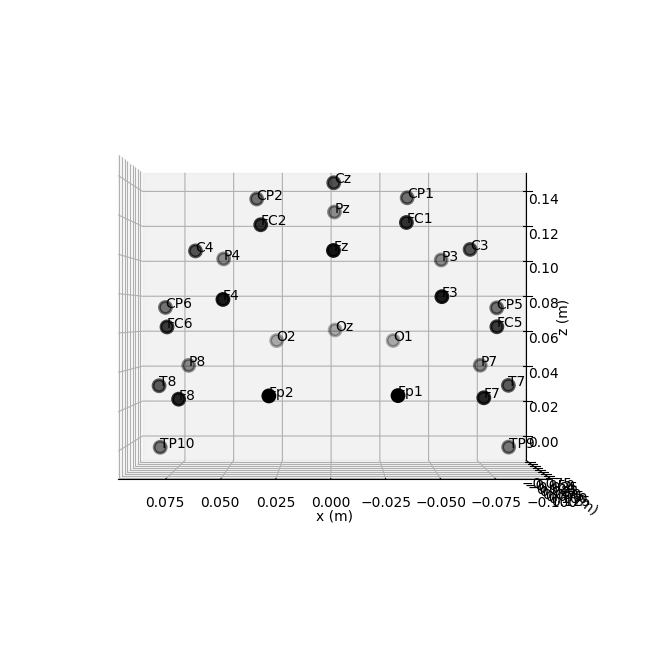

In [14]:
graph2=original_eeg['01'].plot_sensors(kind='3d', show_names=True)

Y lo último, pero ni de lejos menos importante, son los métodos para poder ver la señal en el tiempo.

<br>

Si ejecutamos MNE-Python en un entorno de desarrollo en nuestras máquinas, tendremos acceso a gráficos interactivos (por los cuales se puede navegar en la señal, como en un video). Sin embargo, en Google Colab, esa opción no está disponible. Igual, podríamos arreglárnoslas para ver la señal en el tiempo, porque al fin y al cabo estamos en Python; pero la verdadera limitante es la capacidad de procesamiento de Google Colab.

<br>

Probemos utilizando el método <code>.plot()</code> del objeto EEG/'raw'. Sin argumentos, ni nada.  

<br>

Accedamos al objeto llamando al diccionario e indicando la clave (id del participante) asociada, para aplicar el método en cuestión.


Using matplotlib as 2D backend.


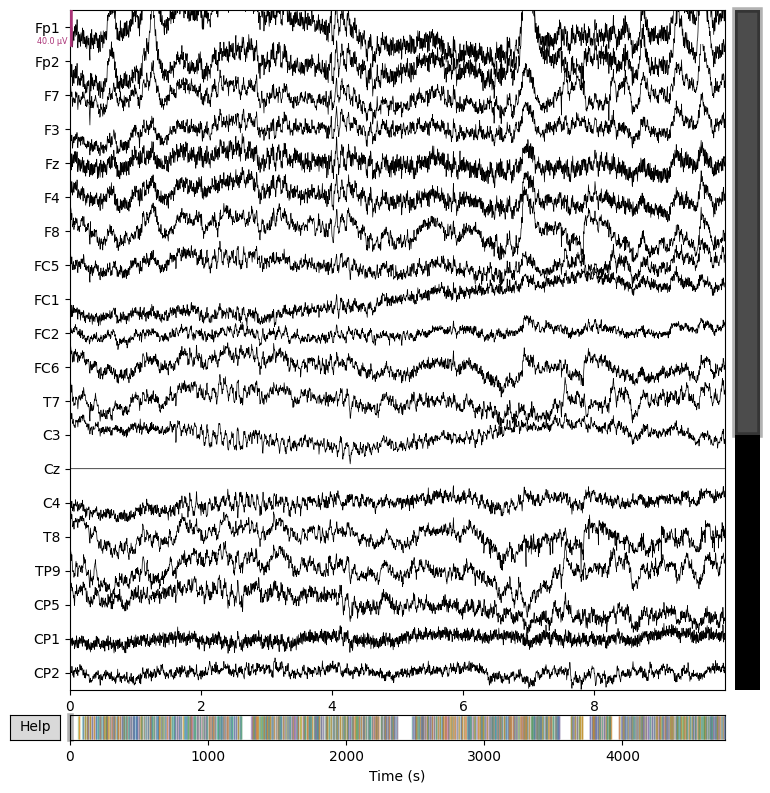

In [15]:
graph1=original_eeg['01'].plot()

# Filtrado y limpieza de artefactos.

El siguiente paso es el filtrado y la limpieza de artefactos.

En realidad, denominarlo como sólo un único paso es subestimar todo lo que es posible hacer para mejorar la señal y librarse de los artefactos o ruido. Recordemos que, si bien estamos midiendo actividad cerebral a nivel del cuero cabelludo, la fuente primaria de voltaje y ritmos todavía se encuentra tras muchas capas.  

Cada una de estas capas, más los factores asociados al experimento, pueden hacer que nos preguntemos:

<br>


---
<br>

<center>

Este voltaje/ritmo... ¿Es producto de la actividad cerebral? ¿O producto de la interacción de algo más con esta?

</center>

<br>


---

<br>

Para responder a esas preguntas, lo ideal es adentrarnos a preguntarnos ¿Qué entendemos por actividad cerebral? ¿Qué es un "ritmo"? o ¿"Voltaje"?  

## Entendiendo los ritmos del cerebro.

Uno de los conceptos más usados hoy en día es el de "frecuencias cerebrales" o "ritmos cerebrales". Se utiliza para hablar acerca de la forma de las ondas que están asociadas a cierta actividad cerebral. A grandes rasgos, las más conocidas son las siguientes:

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/02.png"
       alt="montaje"
       style="display:block; margin:0 auto; max-width:100%; width:1080px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Frecuencias de actividad cerebral.</figcaption>
</figure>

<br>

Pero ¿Qué es un ritmo? ¿Qué es una frecuencia? Para dar con el concepto clave, podemos aproximarnos de la manera más ingenua: Una frecuencia es cuán frecuente es algo, cuánto sucede en el tiempo.

Si algo sucede a una frecuencia de 1Hz, es lo mismo que decir que sucede cada segundo. Si sucede 10Hz, sucede 10 veces por segundo (0.1 ms), y así sucesivamente.

**¿Pero qué es lo que sucede?**  

En este caso, de cuántas oscilaciones suceden en el tiempo.  

En el ejemplo hipotético, todas las oscilaciones son matemáticamente perfectas, pero en los EEG no **¿Entonces? ¿Cómo hacemos?**

<br>

Por suerte, no somos los primeros que se hacen esa pregunta. En realidad, muchas veces lo que se hace es un intento matemático de estimar una señal compleja en sus señales más simples. Tanto para medirla, construirla o deconstruirla.

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/01.png"
       alt="montaje"
       style="display:block; margin:0 auto; max-width:80%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Frecuencias juntas.</figcaption>
</figure>


<br>

Todas estas tretas matemáticas han servido para darnos cuenta de que el cerebro tiene frecuencias específicas durante ciertos estados, ya sea actividad, sueño, estrés, percepción de ambigüedad, etc.

<br>

Ojo, frecuencias en la medición de EEG cortical, porque la realidad es más compleja.

<br>



<center>



> ¿Puede el cerebro tener latidos distintos al mismo tiempo?



</center>

<br>

<br>

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/03.png"
       alt="montaje"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Diferencia de frecuencias entre pliegues.       <a href="https://www.nature.com/articles/s41593-023-01554-7"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      Fuente.
  </a></figcaption>
</figure>

<br>

<br>

<br>

<br>

<br>

<br>


In [16]:
#@title Black Box_(Ｙｏｕ have encountered ａｎｏｔｈｅｒ BlackBox. What would you do?)
# Bandas EEG y sus rangos
eeg_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alfa": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100)
}

eeg_colors = {
    "Delta": "#00ffd5",
    "Theta": "#ff00ff",
    "Alfa": "#b6ff00",
    "Beta": "#ff6ec7",
    "Gamma": "#00ffff"
}

def get_band_and_color(freq):
    for name, (low, high) in eeg_bands.items():
        if low <= freq < high:
            return name, eeg_colors[name]
    return "Fuera de rango", "#ffffff"

def plot_senoide(freq, dur):
    fs = 1000
    t = np.arange(0, dur, 1/fs)
    y = np.sin(2 * np.pi * freq * t)

    band_name, color = get_band_and_color(freq)

    fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
    fig.patch.set_facecolor("#0a0f1f")
    ax.set_facecolor("#0a0f1f")

    ax.plot(t, y, linewidth=8, alpha=0.08, color=color)
    ax.plot(t, y, linewidth=2.2, color=color)

    ax.set_xlim(0, dur)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel("Tiempo (s)", color="#cde3ff")
    ax.set_ylabel("Amplitud", color="#cde3ff")
    ax.set_title(
        f"Frecuencia: {freq:.2f} Hz  →  Banda: {band_name}",
        color="#e6f0ff",
        pad=10
    )

    for spine in ax.spines.values():
        spine.set_color("#20345c")
        spine.set_linewidth(1.2)

    ax.tick_params(colors="#a8c8ff")
    ax.grid(True, which="both", linewidth=0.6, alpha=0.25)
    plt.tight_layout()
    plt.show()

# Sliders
freq_slider = ipywidgets.FloatSlider(
    value=10.0, min=0.5, max=50.0, step=0.5,
    description='Frecuencia (Hz):'
)

dur_slider = ipywidgets.FloatSlider(
    value=1.6, min=0.1, max=1.0, step=0.1,
    description='Duración (s):'
)

ipywidgets.interactive(
    plot_senoide,
    freq=freq_slider,
    dur=dur_slider
)


interactive(children=(FloatSlider(value=10.0, description='Frecuencia (Hz):', max=50.0, min=0.5, step=0.5), Fl…

## Frecuencias que no pertenecen al cerebro.

<br>

El EEG capta muchas frecuencias, entre ellas la de la alimentación de corriente eléctrica (50hz / 60hz dependiendo del país), la de contaminación de aparatos eléctricos cercanos, etc.

<br>

Incluso, frecuencias que no pertenecen a la actividad cerebral pueden ser transmitidas mediante el participante también, puesto que los movimientos musculares o de la mandibula influyen en la señal captada.

<br>

Para esto, existen convenciones de filtrado en los estudios de EEG. Normalmente se filtran afuera las frecuencias específicas de la electricidad (mediante un filtro llamado notch) y luego se hace un filtrado de un rango de frecuencias específicas. Esto se llama ``bandpass filter``. Es básicamente decir "quiero que midas las frecuencias desde este valor hasta este otro valor".  

<br>

En este caso, el intervalo de esos valores idealmente son las frecuencias que nos interesan: las que pertenecen al cerebro o a la actividad que se estudia.  

<br>


## Las referencias. Unidades de medición.

¿Existe una unidad de medición absoluta?

<br>

Toda medición se suele hacer siempre respecto a una referencia. Si digo "2 segundos", "1 día", "2 kilómetros", siempre estoy asumiendo un punto de comparación (desde que cuento, desde que el lugar que empiezo a medir). Medir suele ser análogo a comparar.  

<br>

En el caso del EEG, el voltaje se mide con electrodos de referencia. Podemos pensar en la idea del voltímetro.

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://cdn.pixabay.com/photo/2014/11/09/02/53/multimeter-523153_1280.jpg"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Voltímetro.</figcaption>
</figure>


Los electrodos sobre los que se suelen medir son los mastoides, pero mientras procesamos los datos podemos cambiar de referencia. Recordemos que sólo es un punto de comparación. En este caso, el punto de comparación del estudio de Isasi-Isasmendi, et al. (2024) fue el promedio de los mastoides (el promedio del valor de dos electrodos como referencia).  

<br>

En estudios de eeg, una referencia común también es el "average reference", que es tomar el promedio de todos los electrodos como punto de referencia.  

<br>

En este caso, comenzaremos con un filtro bandpass y luego con la asignación de la referencia al promedio de los mastoides. Los métodos que utilizaremos los tiene el objeto EEG/'Raw': <code> .filter</code> y <code> .set_eeg_reference</code>.




<br>


<br>




<table>
  <tr><th colspan="2" align="left">Método: <strong>.filter
  <br><br>
  Objeto mne.io.Raw
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>l_freq</td><td>Frecuencia que estará en el límite inferior. Sólo pasarán las frecuencias más altas que esta. En nuestro caso: 0.1. </td></tr>
<tr><td>h_freq</td><td>Frecuencia que estará en el límite superior. Sólo pasarán las frecuencias más bajas que esta. En nuestro caso: 40. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
El mismo objeto con el paso de banda aplicado. Sólo pasan las frecuencias entre 0.1 y 40 Hz.
</table>



<br>


<table>
  <tr><th colspan="2" align="left">Método: <strong>.set_eeg_reference <br><br> Objeto mne.io.Raw</strong>
  
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>ref_channels</td><td>Canal que será la nueva referencia. Si es una lista, se promedian los canales. Si es 'average', se referencia al promedio de todos los electrodos. </td></tr>

<td colspan="2">
El mismo objeto con la referencia aplicada.
</table>

In [17]:
#No estamos aplicando un notch_filter porque el filtro de paso de banda ya deja fuera la corriente.
filtered_eeg={}
for sub, eeg in original_eeg.items():
  eeg=eeg.copy()
  eeg=eeg.filter(l_freq=0.1, h_freq=40)
  eeg=eeg.set_eeg_reference(ref_channels=['TP9', 'TP10'])
  filtered_eeg[sub]=eeg

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (33.004 s)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower

## Remover electrodos con señal dañada

<br>

Otra práctica común es remover electrodos que no están funcionando bien. En el paper que intentamos replicar, utilizaron un criterio concreto: los electrodos con señal que superaba 5 desviaciones estándar de la media de todos los electrodos eran removidos.  

<br>

Aquí intentaremos replicar lo que hicieron con una librería que se integró a MNE: **PyPrep**.  

<br>


---

<br>

> <left>
PyPrep es un paquete que se encarga de implementar el pipeline PREP para descartar electrodos dañados.

</left>

<br>

---

<br>

Dentro de Pyprep tenemos varias técnicas para descartar electrodos:

*   Correlación con los demás
*   Comparación con la Desviación Estándar de la media de electrodos.
*   RANSAC (Random Sample Consensus)
*   SNR (Signal to Noise Ratio)
*   High frequency noise o Ruido de alta frecuencia.
*   Señales vacías.

, etc. En esta ocasión, utilizaremos el método ```.find_bads_by_deviation```, que nos permite detectar electrodos dañados en base a la desviación estándar.

<br>

Para ello, tendremos que construir un objeto PyPrep con ciertas características que que queremos que se apliquen en el pipeline. Este objeto se creará mediante la función <code> pyprep.NoisyChannels </code>. El método ```.find_bads_by_deviation``` se aplica al nuevo objeto.


<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>pyprep.NoisyChannels</strong>
  
  </strong>
      <a href="https://pyprep.readthedocs.io/en/latest/generated/pyprep.NoisyChannels.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>raw</td><td>Archivo EEG/'Raw' de MNE. PyPrep sólo se puede aplicar a este nivel. </td></tr>
<tr><td>do_detrend</td><td>True or False. PyPrep puede filtrar la señal por nosotros, poniéndole un límite inferior de 1. En este caso, nuestra señal ya está filtrada, así que será False. </td></tr>
<tr><td>random_state</td><td>Métodos internos de PyPrep usan la simulación aleatoria para comparar si los valores se deben al azar. Aquí escogemos un "seed" o dimensión en la que queremos que se ejecute lo aleatorio (7). </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto PyPrep con métodos que pueden aplicarle técnicas de rechazo de electrodos.
</table>

<br>
<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.find_bad_by_deviation</strong>
<br><br> Objeto pyprep.NoisyChannels</strong>
  </strong>
      <a href="https://pyprep.readthedocs.io/en/latest/generated/pyprep.NoisyChannels.html#pyprep.NoisyChannels.find_bad_by_deviation"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
<tr><td>deviation_threshold</td><td>Umbral (en valores normalizados o Z-scores) para ejecutar el rechazo. Utilizaremos el valor 5.0 para rechazar si se aleja más de 5 DE de la media. </td></tr>

</table>

<br>

In [18]:
#Luego está la selección a nivel de electrodos:
for sub, eeg in filtered_eeg.items():
  noisy=pyprep.NoisyChannels(raw = eeg,
                            do_detrend=False, #Importante para que la herramienta no aplique un filtro por nosotros.
                            random_state=7)
  noisy.find_bad_by_deviation(deviation_threshold=5.0) #Esto es lo que se aplicó en el paper.
  eeg.info['bads'] = noisy.get_bads()
  results=noisy.get_bads(as_dict=True)
  print(f"Se encontró {len(eeg.info['bads'])} canales ruidosos")

Se encontró 0 canales ruidosos
Se encontró 0 canales ruidosos
Se encontró 0 canales ruidosos
Se encontró 1 canales ruidosos
Se encontró 0 canales ruidosos


Si se dieron cuenta, utilizamos al final el método `.get_bads`, para poder recuperar la información de los canales rechazados.  

Esta información la estamos copiando en el atributo `.info` del objeto original, que guarda datos relacionados a la señal.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.get_bads</strong>
<br><br> Objeto pyprep.NoisyChannels</strong>
  </strong>
      <a href="https://pyprep.readthedocs.io/en/latest/generated/pyprep.NoisyChannels.html#pyprep.NoisyChannels.get_bads"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>





<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Diccionario con los electrodos rechazados.
</table>

</table>


<br>

<table>
  <tr><th colspan="2" align="left">Atributo: <strong>.info</strong>
<br><br> Objeto mne.io.Raw</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>


<br>

<tr><th colspan="2" align="left">Objetos a los que accede:</th></tr>

<td colspan="2">
Un diccionario con la metadata (o simplemente data sobre el EEG). Utilizamos la key 'bads' para agregar información de los electrodos dañados.
</table>


In [19]:
#@title Black Box (Inspeccionar Electrodos)
def plot_sensors(sub):
    object = filtered_eeg[sub]
    object.plot_sensors(
        kind='topomap',
        show=True,
        show_names=True
    )

toggle_sub=ipywidgets.ToggleButtons(
    options=['23', '05', '04', '02', '01'],
    description='Sub Key:',
    disabled=False,
    button_style='',
    style={'button_width':'5em'},
)
label = ipywidgets.HTML(
    value="<div style='font-size:18px; text-align:left;'>¿Qué sujeto tiene electrodos rechazados?</div>"
)

sensor_widget = ipywidgets.interactive(
    plot_sensors,
    sub=toggle_sub
)

ipywidgets.VBox([label, sensor_widget])



De momento, podemos recapitular los pasos de pre procesado que hemos hecho hasta ahora.

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_02.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Estado del tutorial.</figcaption>
</figure>


# Independent Component Analysis (ICA)

Algunos dirían que es el peso pesado, otros que no siempre es necesario. Querido, odiado y muchas veces incomprendido. La realidad es que el ICA es una de las herramientas más usadas en el pre-procesamiento de EEG.

<br>

Usa el principio matemático de detectar comportamientos singulares en la señal, que parecen presentarse de manera invariable e independiente de la tendencia general.

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/47/4._Fish_at_Sea_Surface_of_Karimunjawa.jpg"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Banco de peces en el mar de Karimunjawa.</figcaption>
</figure>

<br>

Si estuviéramos en el océano y viésemos, además de las olas, ondas particulares, podríamos deducir que hay algo distinto bajo el agua. El ICA usa principios similares para detectar componentes que no pertenecen al patrón inherente de la señal; detecta fuentes "independientes" de ondas. Independientes, en este caso, al resto de la señal.

<br>

Luego de tretas matemáticas complejas, el ICA nos da un mapa con componentes independientes y nos permite seleccionar los elementos que no queremos.

<br>

-----

<br>


<center>

El objetivo es borrar los componentes que sabemos que no pertenecen a la señal cerebral.

</center>

<br>


-----



<br>
<br>
<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/04_ai.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Analogía de componentes.</figcaption>
</figure>




<br>

Al retirar los elementos innecesarios, aplica el mapa resultante sobre los datos para reconstruirlos. Esto se conoce como "limpiar los datos".

<br>

<h2>Recomendaciones generales para el ICA</h2>

<br>

El consenso general es que el ICA suele ser sensible al ruido de baja frecuencia. Debido a ello, es "entrenado" con la señal original, pero filtrada con un high-pass de 1.0 Hz (es decir, eliminando las ondulaciones más lentas). Como es una solución geométrica/estadística, el mapa resultante del entrenamiento puede ser aplicado a la señal original o con otro filtrado. Pero hay que tener consideraciones importantes:

<br>

*   La señal de entrenamiento y la de recepción deben tener la misma dimensionalidad (mismo número de electrodos, por ejemplo).
*   Se recomienda que para, ver los efectos reales, la señal de entrenamiento tenga la misma referencia de la señal de recepción.
*   El ICA se considera una transformación **lineal**. Esto quiere decir que es reversible. Una señal transformada con un mapa puede ser destransformada con la información del mismo mapa. Sin embargo, si realizamos un cambio entre esas transformaciones, no será posible recuperar la señal.

<br>

<h2>Creando datos de entrenamiento para el ICA</h2>

<br>

Preparémonos para aplicar el ICA. Primero, necesitamos una señal filtrada para no dejar pasar las frecuencias lentas. Se recomienda un filtro `l_freq=1.0, h_freq=None`, pero esta vez utilizaremos 1.0 - 100. No se preocupen, luego esto tendrá bastante sentido.

<br>

<center>

> Nuestra señal ya fue filtrada de 0.1 a 40 Hz. Ya no podemos recuperar las frecuencias mayores a 40Hz. Debido a ello, tendremos que acudir a nuestra señal original sin filtrar para hacer una copia.

</center>

<br>

Como en la nueva señal nos quedaremos con las frecuencias entre 40Hz y 100Hz, tendremos que aplicar un filtro para librarnos de la frecuencia de la corriente del artefacto. Estos filtros específicos se llaman notch, y podemos hacerlo con el método `.notch_filter`.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.notch_filter</strong>
<br><br> Objeto mne.io.Raw</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.notch_filter"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>


<tr><td>freqs</td><td>Frecuencia o frecuencias que queremos filtrar. Si ponemos una lista, tendrá que ser entre paréntesis. Utilizaremos (50,60) para filtrar 50Hz y 60Hz. </td></tr>


<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto EEG filtrado.
</table>

</table>


<br>


Luego del filtro notch, recuperaremos los electrodos dañados copiando la información de ```.info['bads']``` de la señal original de cada participante, pues a esta ya aplicamos el criterio de rechazo de 5 desviaciones estándar.

<br>

El siguiente paso sería re-referenciar la señal también con ```.set_eeg_reference```. Guardaremos los datos para entrenar el ICA en el diccionario ```train_eeg```


En general, queremos seguir el siguiente flujo:



<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_03.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Flujo con copia de entrenamiento.</figcaption>
</figure>


In [20]:
############################################
#########Preparing training data############
############################################
#Creamos un diccionario para guardar las copias de entrenamiento
train_eeg={}

#Empezamos iterando en el diccionario de los datos originales.
for sub, eeg in original_eeg.items(): #devuelve pares key:value. Ej: '23', ObjectoEEG.
  train_copy=eeg.copy()
  train_copy=train_copy.filter(l_freq=1.0,
                              h_freq=100 #¡¿Cómo?!
                              )
  train_copy.notch_filter( #Nuestro filtro notch
      freqs=(50, 60)
      )
  train_copy.info['bads'] = filtered_eeg[sub].info['bads'] #copiamos la información sobre los canales que se encontraron dañados (las marcas "bad channel")
  train_copy=train_copy.set_eeg_reference('average')
  #Guardamos en el diccionario. La key es la variable 'sub' en la iteración, la cual guarda el id del sujeto.
  train_eeg[sub]= train_copy

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

EEG channel type 

Y aquí ya estaríamos listos para el ICA. Sin embargo, un dato clave para el ICA es la dimensionalidad de nuestra data.

<br>

<center> <em>

> ¡¿Y cómo se hace eso profe?! Ya me mareé ¡¿Y ahora tengo que hacer matemáticas?!
</em>  
(ノಠ益ಠ)ノ彡┻━┻ </center>

<br>

¡Tranquilos! Por suerte, estamos en Python, así que el trabajo duro lo hará una función (*¿o el trabajo duro era pensar para qué usar las funciones?...*).

<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.compute_rank</strong></strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.compute_rank.html#mne.compute_rank"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>


<tr><td>inst</td><td>Archivo EEG del cual queremos que compute la dimensionalidad. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Diccionario que contiene: tipo de canal(key) y rango (value). En nuestro caso, sólo tendremos 'eeg': rank. Con los parámetros por defecto, el rango es un indicador de la dimensionalidad.
</table>


<br>


El rango es un simple número entero (como 32, 30, 28). Este número será un parámetro de nuestro ICA.

<h2>Creando el ICA</h2>

¡Ahora sí! Ya podemos aplicar el ICA. Para ello, crearemos un nuevo objeto (casi como lo hicimos en PyPrep), el cual contendrá los parámetros de nuestro análisis.


<table>
  <tr><th colspan="2" align="left">Función: <strong>mne.preprocessing.ICA</strong></strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>


<tr><td>n_components</td><td>El número de componentes que queremos que estime. Aquí es donde va el número del rank. </td></tr>
<tr><td>method</td><td>Método para realizar la computación. Elegiremos 'infomax'. </td></tr>
<tr><td>fit_params</td><td>Diccionario que indica los parámetros adicionales del método. {'extended':True} para infomax extendido. </td></tr>
<tr><td>max_iter</td><td>Controla el número de iteraciones para el cálculo. 'auto' para que la función decida por sí sola. </td></tr>
<tr><td>random_state</td><td>Seed para replicabilidad. Universo 7. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objecto ICA con los parámetros que definimos. Listo para entrenarse con una señal.
</table>


<br>

El objeto que obtenemos aún no está entrenado. Para hacer esto, usamos el método <code>.fit</code> para seleccionar la señal con la que se entrenará.

<br>


<table>
  <tr><th colspan="2" align="left">Método: <strong>.fit</strong></strong>
  </strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.fit"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>


<tr><td>inst</td><td>La data eeg que se quiere para entrenar el ICA y dibujar los "mapas". </td></tr>
<tr><td>picks</td><td>Tipo de canales que se quieren considerar para construir los mapas ICA. Por default canales que tienen señal cerebral ('eeg' o 'meg' por ejemplo). Es buena práctica siempre delimitarlo de forma explícita ('eeg' en nuestro caso). </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objecto ICA con el mapa de transformación y destransformación.

</table>

In [21]:


"""
NO EJECUTAR ESTE CÓDIGO.

Ejecutar este código podrá romper el entorno Colab, porque no tiene suficiente
capacidad para procesar el ICA en un tiempo aceptable.

Para ejecutarlo, si se quiere rehusar, es necesario quitarle las comillas
con las que empieza y termina

########################
#########ICA############
########################
#Creemos un diccionario para guardar soluciones ica
ica_objects={}
for sub, eeg in train_eeg.items(): #Iteramos en los datos de entrenamiento.
  rank_train_dictionary=mne.compute_rank(eeg)
  rank_train=rank_train_dictionary['eeg']

  ica = mne.preprocessing.ICA(
              n_components=rank_train, #Rank o dimensiones independientes.
              method = "infomax",  # Método a elegir.
              fit_params = {'extended':True}, #Parámetros del método, hay "infomax" e "infomax extended". Queremos el extended.
              max_iter = "auto",  # Maximum number of iterations; typically should be higher, like 500 or 1000
              random_state = 7  # Lucky!
          )

  ica.fit(eeg, picks='eeg') #eeg es por default, pero es buena práctica.

  ica_objects[sub]=ica


  """

'\nNO EJECUTAR ESTE CÓDIGO.\n\nEjecutar este código podrá romper el entorno Colab, porque no tiene suficiente\ncapacidad para procesar el ICA en un tiempo aceptable.\n\nPara ejecutarlo, si se quiere rehusar, es necesario quitarle las comillas\ncon las que empieza y termina\n\n########################\n#########ICA############\n########################\n#Creemos un diccionario para guardar soluciones ica\nica_objects={}\nfor sub, eeg in train_eeg.items(): #Iteramos en los datos de entrenamiento.\n  rank_train_dictionary=mne.compute_rank(eeg)\n  rank_train=rank_train_dictionary[\'eeg\']\n\n  ica = mne.preprocessing.ICA(\n              n_components=rank_train, #Rank o dimensiones independientes.\n              method = "infomax",  # Método a elegir.\n              fit_params = {\'extended\':True}, #Parámetros del método, hay "infomax" e "infomax extended". Queremos el extended.\n              max_iter = "auto",  # Maximum number of iterations; typically should be higher, like 500 or 1000\

# Practicar ICA

<h2>Recuperación de soluciones ICA</h2>

<p>
Google Colab puede demorar al aplicar ICA. Sin embargo, como al final el ICA produce
<i>mapas</i> (matrices de mezcla y desmezcla), podemos guardarlos y recuperarlos
como objetos independientes.
</p>



<p>
En este caso, nuestra caja negra recuperará el <b>mapa del participante 23</b>
(como un objeto ICA), el cual fue preprocesado junto con todos los demás con el código anterior.
</p>


<details open>
    <summary><b>¿Por qué guardar los mapas?</b></summary>
    <ul>
      <li>Evitar recalcular ICA completo entre sesiones de análisis.</li>
      <li>Reproducibilidad: Documentar el resultado de seguir el mismo <i>pipeline</i> y usar los mismos objetos.</li>
      <li>Facilita análisis detenido por participante.</li>
    </ul>
</details>


<br>

Al recuperar los mapas del ICA nos abremos saltado una parte del flujo, vamos a recapitular para no perdernos:

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_04.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Flujo al saltarnos la computación.</figcaption>
</figure>

In [22]:
#@title Black Box_(download solution objects)
%%capture
!wget "https://drive.usercontent.google.com/download?id=1GJD2iwv9UOOCbHIYTpWTYXwykyB0_eYU&export=download&confirm" -O withoutlabel.zip
!unzip -o withoutlabel.zip -d /content/
ica = mne.preprocessing.read_ica("./objects_unlabeled/23_ica.fif")

In [23]:
ica

Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,90 iterations on raw data (990965 samples)
ICA components,28
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


<h2>Participante 23</h2>


El objeto ICA del participante 23 intentó encontrar 28 componentes (se evaluó que nuestros datos tenían 28 dimensiones, así que ese era el número máximo lógico).  

Intentemos aplicar el mapa a nuestros datos. Como ya ejecutamos el filtrado, accedemos al diccionario y hacemos una copia del objeto de entrenamiento con el que se dibujó el mapa.

In [24]:
#Creemos una copia del objeto original del participante 23.
single_test_sub=train_eeg['23'].copy()

<h2>Explorando soluciones ICA</h2>

<br>

Lo primero que podemos hacer es aplicar el método `.plot_components()`, así sin nada más, ni un argumento. <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_components"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [documentación del método]
  </a>


<br>


Esto nos dará las topografías de los componentes en donde observaremos la actividad de cada componente en los electrodos.


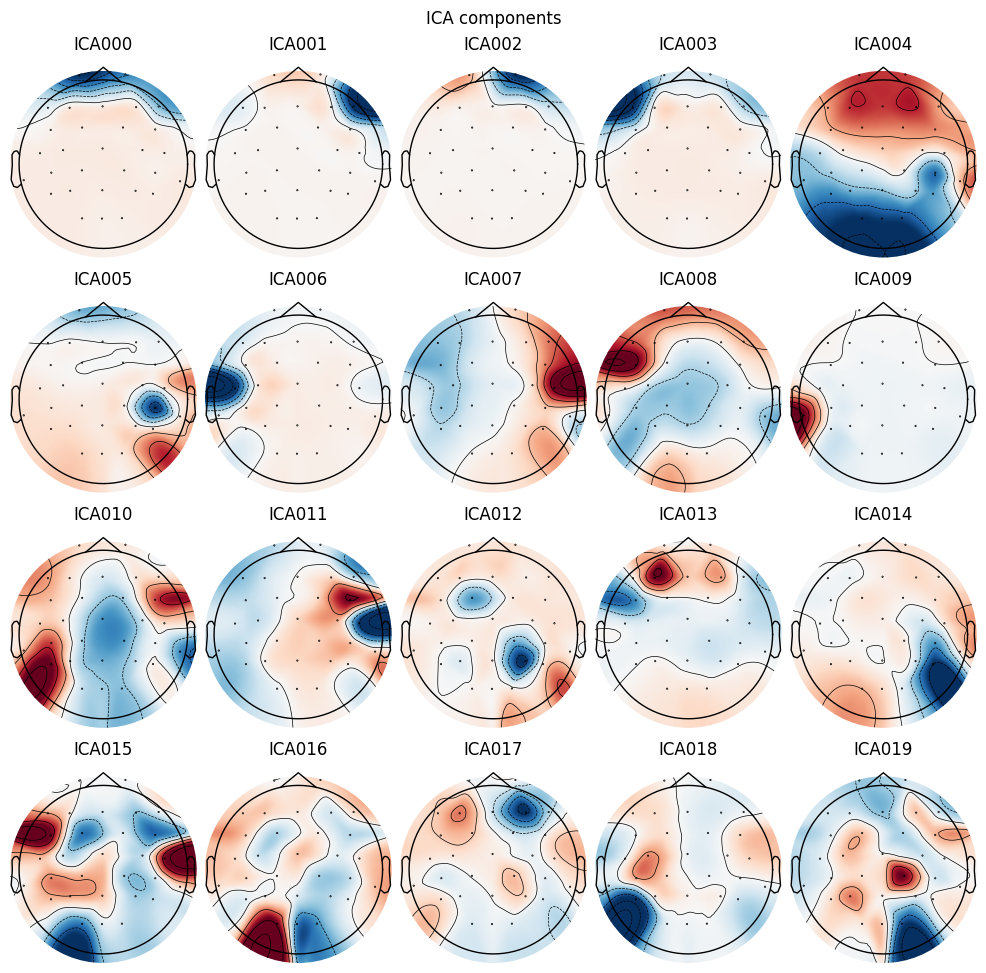

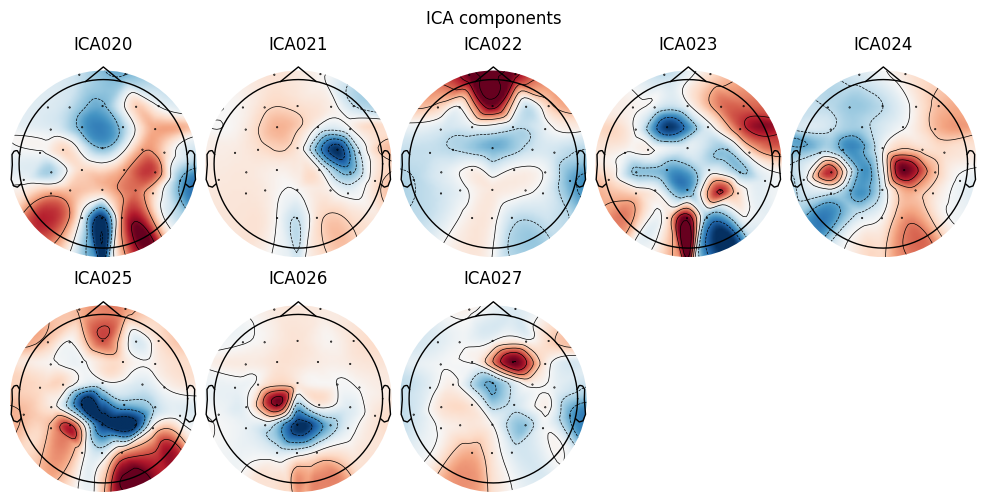

In [25]:
graph=ica.plot_components()

Si ejecutamos MNE en nuestras computadoras, estos gráficos serán interactivos. Es decir, nos abrirán ventanas con los detalles de cada componente. Sin embargo, también hay formas para obtener esa información si no disponemos de una interfaz interactiva. Utilizaremos los métodos .`plot_properties ` y `.plot_sources`.


<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_properties</strong></strong>
  </strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_properties"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>inst</td><td>La data eeg para estimar señales de componentes. Aquí irá "single_test_sub", pues es la copia de la data con la que entrenamos. </td></tr>
<tr><td>picks</td><td>Índices de los componentes o lista de índices de los componentes. Iremos por el 3. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Figura con detalles de la señal del componente.
</table>

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_sources</strong></strong>
  </strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_sources"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>inst</td><td>La data eeg para estimar señales de componentes. Aquí irá "single_test_sub", pues es la data con la que entrenamos. </td></tr>
<tr><td>picks</td><td>Índices de los componentes o lista de índices de los componentes. Iremos por el 3 para complementar las properties. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Figura con la señal de cada componente. Por default, se muestra también la señales de los electrooculogramas del aparato (HEOG, VEOG) para ayudar a examinar si los componentes pertenecen a señales oculares.
</table>

<br>



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1981 matching events found
No baseline correction applied
0 projection items activated


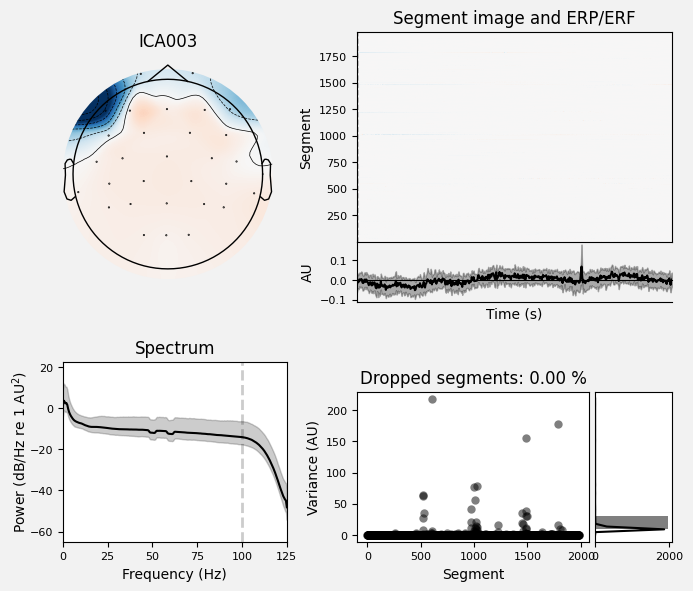

Creating RawArray with float64 data, n_channels=3, n_times=990965
    Range : 0 ... 990964 =      0.000 ...  3963.856 secs
Ready.


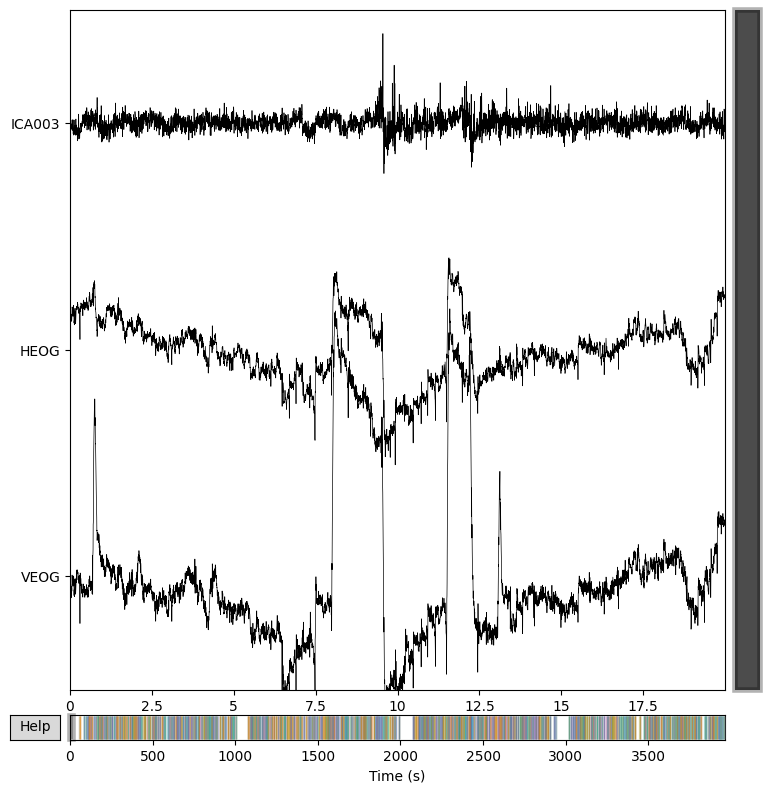

In [26]:
graph1=ica.plot_properties(inst=single_test_sub, picks=[3])
graph2=ica.plot_sources(inst=single_test_sub, picks=[3])

In [27]:
#@title Black Box (Explorar componentes)
def ica_plot_properties(picks):
    ica.plot_properties(inst=single_test_sub,
             picks=picks,
             show=True)
toggle=ipywidgets.ToggleButtons(
    options=[0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27],
    description='Componente:',
    disabled=False,
    button_style='',
    style={'button_width':'12em'}
)

component_widget = ipywidgets.interactive(
    ica_plot_properties,
    picks=toggle
)

display(component_widget)

interactive(children=(ToggleButtons(description='Componente:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

Recordemos la finalidad del ICA: Seleccionar componentes que no pertenecen a actividad cerebral. Si queremos marcar componentes, podemos agregar el índice del componente al atributo `.exclude`, el cual almacena una lista de componentes para excluir. <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.fit"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [documentación en la parte de "atributos"]

In [28]:
#Veremos que nuestra lista está limpia
ica.exclude

#Si quisiéramos agregar, podríamos hacer lo siguiente
#ica.exclude=1
#ica.exclude=[0,4]

[]

Recapitulación secuencial:

´training eeg´

<h2>Técnicas para detectar componentes de artefactos: <code>find_bads_eog</code> e ICALabel</h2>

Dos de las técnicas más accesibles y a la vez eficientes que tiene MNE para detectar componentes que pertenecen a artefactos, son el método <code>find_bads_eog</code> y la librería complementaria <span style="text-transform:uppercase; font-size:0.9em; letter-spacing:0.5px;">
ICALabel.
</span>

<br>



<h2><code>find_bads_eog</code></h2>


<br>

<code>find_bads_eog</code> se encarga de descartar componentes encontrados por el ICA en base a la correlación que tiene con la señal de los electrooculograma (EOG).  

<br>

En teoría, si nuestro componente tiene una fuerte correlación con lo que sucede en el EOG, que se encarga de medir los cambios de potencial alrededor de los ojos, entonces no pertenecería a actividad cerebral.  

<br>

Podemos configurar el umbral que la función utiliza para decidir si el componente se parece o no a la señal del EOG, en este caso, utilizaremos el valor por defecto <code>0.3</code>. De igual forma, mediante el parámetro <code>ch_name</code> le decimos al método contra qué canales queremos que se haga la comparación. En este estudio, se tuvieron dos EOG dedicados: <code>HEOG</code> y <code>VEOG</code>.

<br>
<table>
  <tr><th colspan="2" align="left">Método: <strong>.find_bads_eog</strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>
  
  </th></tr>
  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>inst(objeto con señal)</td><td>La señal sobre la cual queremos que se compute el método.</td></tr>
  <tr><td>ch_name</td><td>El nombre de los canales para utilizar como "EOG" en el cálculo. En este caso "VEOG" y "HEOG".</td></tr>
  <tr><td>threshold</td><td>Umbral por sobre el cual el componente es clasificado como valor extremo o no (outlier, anómalo). </td></tr>
  <tr><td>verbose</td><td>Controla si queremos datos del estado del proceso. Por default True, pero para outputs más legibles lo setearemos en False. </td></tr>
  <tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

  <td colspan="2">
  Dos diccionarios, uno con el índice de los objetos detectados como pertenecientes a artefactos, y otro con el índice de correlación de todos los componentes.
</table>

In [29]:
#ya tenemos el objeto ica
ica #esto ya existe
#find_bads_eog
eog_indices, eog_scores = ica.find_bads_eog( #Este es el método.
    single_test_sub, #pasamos nuestro set de entrenamiento
    ch_name=['HEOG', 'VEOG'],
    threshold=3.0,
    verbose=False
)

print(eog_indices)
print("Estos componentes han sido detectados, pero aún faltan ser agregados al atributo .exclude")

[np.int64(7), np.int64(10)]
Estos componentes han sido detectados, pero aún faltan ser agregados al atributo .exclude


<h2>ICALabel</h2>
<br>

El segundo instrumento que veremos para detectar componentes con artefactos será el de una librería diseñada para "etiquetarlos": icalabel

<br>

Esta librería es una de las tantas disponibles en software privado, como EEGLab, para automáticamente detectar componentes artefactuales. Se basa en la lógica de etiquetar a cada componente como: <code>'brain', 'muscle artifact', 'eye blink', 'heart beat', 'line noise', 'channel noise' or 'other'</code>.  

<br>


Luego de asignar una etiqueta, también asigna una probabilidad de la certeza de dicha etiqueta, indicándola con un número entre 0 y 1. ICALabel fue originalmente entrenado en data de EEG que cumplía con las siguientes características:

<br>

<details open>
    <summary><b>Características de los objetos ICA con los que fue entrenado originalmente ICALabel:</b></summary>
    <ul>
      <li>Fueron computados a partir de señales filtradas entre 1.0 y 100 Hz.</li>
      <li>Las señales también se encontraban referenciadas al "common average".</li>
      <li>Los objetos (mapas) ICA obtenidos fueron producto del método "extended infomax".
    </ul>
</details>

<br>

Ya podemos entender un poco mejor por qué escogimos en nuestro flujo esos parámetros. Sin embargo, a pesar de que ICALabel recomienda que los datos tengan esas características, sí puede ser aplicado en soluciones ICA de datos con filtrados y referencias distintas. No obstante, se advierte que el desempeño del algoritmo puede variar.

<br>

<table>
  <tr><th colspan="2" align="left">Función: <strong>mne_icalabel.label_components
  </strong>
      <a href="https://mne.tools/mne-icalabel/stable/generated/api/mne_icalabel.label_components.html#mne_icalabel.label_components"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
    </a>
  </th>
  </tr>

  <tr><th colspan="1">Parámetros</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>inst(objeto con señal)</td><td>La señal sobre la cual queremos que se proyecte el mapa ica en la función.</td></tr>
  <tr><td>ica (objeto ica)</td><td>La solución ica (mapa) que queremos utilizar para etiquetar.</td></tr>
  <tr><td>method</td><td>Método para etiquetar. Puede ser "icalabel" o "megnet" (para datos MEG usando redes neuronales). </td></tr>
  <tr><th colspan="1">Objetos que retorna la función</th><th colspan="1" align="left">Descripción</th></tr>
  <tr><td>component_dict</td><td>Diccionario con las llaves "y_pred_probs" para acceder a los valores de probabilidades y la clave "labels" para acceder a los valores de las etiquetas.</td></tr>
</table>

In [30]:
#ICLabel
ic_labels = mne_icalabel.label_components(
    single_test_sub,
    ica,
    method="iclabel"
    )

labels = ic_labels["labels"] #obtenemos las "labels" o descripciones de los componentes.
probs = ic_labels["y_pred_proba"] #obtenemos las probabilidades de cada label.
exclude_idx = [
    idx for idx, (label, prob) in enumerate(zip(labels, probs))
    if label not in ["brain", "other"] and prob > 0.9 #seleccionamos las labels, y solamente las agregamos si tienen una probabilidad de 0.9
    ]

print(labels)
print(probs)

['eye blink', 'muscle artifact', 'muscle artifact', 'eye blink', 'brain', 'channel noise', 'muscle artifact', 'brain', 'other', 'muscle artifact', 'brain', 'muscle artifact', 'other', 'other', 'brain', 'other', 'brain', 'eye blink', 'other', 'brain', 'other', 'brain', 'other', 'other', 'brain', 'other', 'brain', 'other']
[0.91783345 0.85734344 0.5566727  0.48370403 0.9979155  0.45158598
 0.9295846  0.8067143  0.8497632  0.6164495  0.50237876 0.754276
 0.55488926 0.42091557 0.67949265 0.9688248  0.5779124  0.47711563
 0.62250715 0.5307245  0.81187975 0.991556   0.9758879  0.7397074
 0.9573953  0.95319986 0.8600511  0.51235676]


Recuperemos la información del objeto ica del participante 23 ya con el atributo `.exclude` modificado con los índices de los componentes que estas herramientas encontraron.

In [31]:
#@title Black Box_(soluciones con etiquetas/labels)
%%capture
!wget "https://drive.usercontent.google.com/download?id=1kkSuLnF7luEdztVXgjxSHpimmCPHwMmn&export=download&confirm" -O labeled.zip
!unzip -o labeled.zip -d /content/
ica_labeled = mne.preprocessing.read_ica("./objects_labeled/23_ica.fif")

Utilizaremos entonces los atributos `.labels` y `.exclude` de los objetos ICA. Estas no son funciones ni métodos, sino características de los objetos. Por su forma de invocarlos, podríamos entenderlos como métodos, mas en la       <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      documentación</a> los encontraremos en el apartado de atributos



In [32]:
display(ica_labeled.labels_)

{'eog/0/HEOG': [7, 10],
 'eog/1/VEOG': [],
 'eog': [7, 10, 0, 3, 17],
 'brain': [4, 7, 10, 14, 16, 19, 21, 24, 26],
 'muscle': [1, 2, 6, 9, 11],
 'ecg': [],
 'line_noise': [],
 'ch_noise': [5],
 'other': [8, 12, 13, 15, 18, 20, 22, 23, 25, 27]}

In [33]:
display(ica_labeled.exclude)

[np.int32(0),
 np.int32(3),
 np.int32(6),
 np.int32(7),
 np.int32(10),
 np.int32(17)]

Podemos ver que la lista está con 6 componentes artefactuales.

<br>

Antes de aplicar el mapa sobre los datos reales, recordemos que se recomienda que estos estén en la misma referencia y rango que los datos entrenados. Intentemos con los datos del participante 23. Referenciemos al common average, computemos sus dimensiones y apliquemos el método `.plot_overlay` para hacer que el mapa ICA nos muestre un gráfico con la señal reconstruida.
<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.plot_overlay</strong></strong>
  </strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.plot_overlay"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>inst</td><td>La data eeg para estimar cómo sería el mapa aplicado. Aquí irá la señal final a la que planeamos aplicar. </td></tr>
<tr><td>exclude</td><td>Índice o lista de índices de componentes que se quieren excluir en la estimación. Aquí irá "ica_labeled.exclude", es decir, la lista .exclude de nuestro nuevo objeto ICA. </td></tr>
<tr><td>picks</td><td>Tipo de canales para aplicar la transformación. Es buena práctica delimitarlo ('eeg' en nuestro caso) </td></tr>

<tr><td>n_pca_components</td><td>Número de componentes para proyectar. Se recomienda siempre proyectar tantos componentes como dimensiones tienen nuestros datos. Como los datos son copias, los valores de la señal de los componentes artefactuales se proyectarán de tal manera que sean anulados ("0"), desapareciendo así de la señal. </td></tr>
<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Figura con la señal reconstruida del objeto EEG. Si el mapa tiene componentes excluidos/tachados, su señal se anulará al ser proyectada.
</table>

In [34]:
#Aplicamos la referencia de 'average' para igualar
subject_to_apply=filtered_eeg['23'].set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [35]:
#calculamos el rango para saber las dimensiones
rank_to_apply_dictionary=mne.compute_rank(subject_to_apply)
rank_to_apply=rank_to_apply_dictionary['eeg']

Computing rank from data with rank=None
    Using tolerance 1.9e-10 (2.2e-16 eps * 30 dim * 2.8e+04  max singular value)
    Estimated rank (eeg): 28
    EEG: rank 28 computed from 30 data channels with 0 projectors


Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components
    Projecting back using 28 PCA components


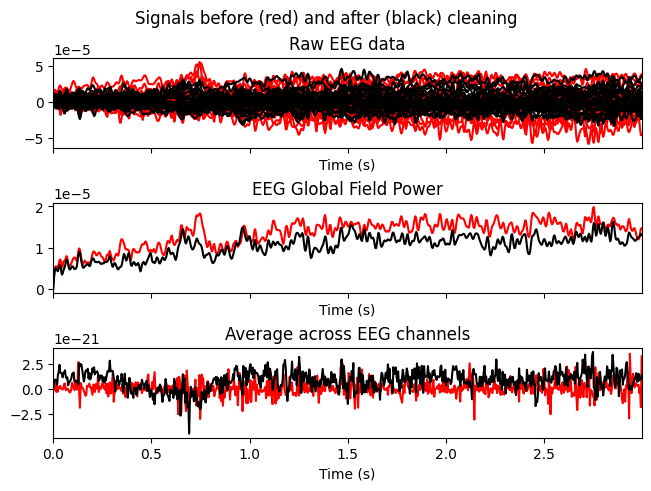

In [36]:
graph1=ica_labeled.plot_overlay(
                 inst=subject_to_apply,
                 exclude=ica_labeled.exclude,
                 picks='eeg',
                 n_pca_components=rank_to_apply
                 )

Vemos que la señal se limpia bastante luego del ICA (la señal roja es la anterior, la que está de negro es la nueva), pero no completamente.

<br>

Hoy en día, se utiliza los métodos automáticos de ICA junto a la inspección manual de componentes. La tendencia es ir reduciendo la intervención humana para mejorar la replicabilidad (es difícil replicar sesgos al seleccionar componentes).

<br>

De hecho, en los estudios con muchos participantes, se optan por pipelines completamente automáticos pues es imposible revisar cada participante.

<br>

La última fase del ICA es el aplicarla finalmente a la señal. Antes estábamos viendo "cómo se veía" al aplicarla, para saber si excluir o no más componentes antes de aplicarla. Ahora, con el método `.apply`, se proyectarán los componentes y se reconstruirá la señal.

<br>

<table>
  <tr><th colspan="2" align="left">Método: <strong>.apply</strong></strong>
  </strong>
  <br><br>
  Objeto mne.preprocessing.ICA</strong>
  </strong>
      <a href="https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.apply"
       target="_blank" rel="noopener" style="margin-left:.5rem; font-weight:normal;">
      [docs]
  </a>

  
  </th></tr>

<br>
<tr><td>inst</td><td>La data eeg para reconstruir. </td></tr>
<tr><td>exclude</td><td>Lista de componentes que serán proyectados como anulados ("zeroed out"). </td></tr>
<tr><td>n_pca_components</td><td>Número de componentes para proyectar. El mismo que las dimensiones de nuestra señal objetivo. </td></tr>

<tr><th colspan="2" align="left">Objetos que retorna:</th></tr>

<td colspan="2">
Objeto EEG/'Raw' con la señal procesada.
</table>

In [37]:
#Probemos aplicando el objeto ica_labeled
final_copy=subject_to_apply.copy() #siempre es buena idea hacer una copia de la señal antes de aplicar la solución.

clean_signal=ica_labeled.apply(
                 inst=final_copy,
                 exclude=ica_labeled.exclude,
                 n_pca_components=rank_to_apply
                 )

Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components
    Projecting back using 28 PCA components


Por último, podríamos utilizar el método `plot`, como en el principio, pero esta vez para ver el cambio de señales.

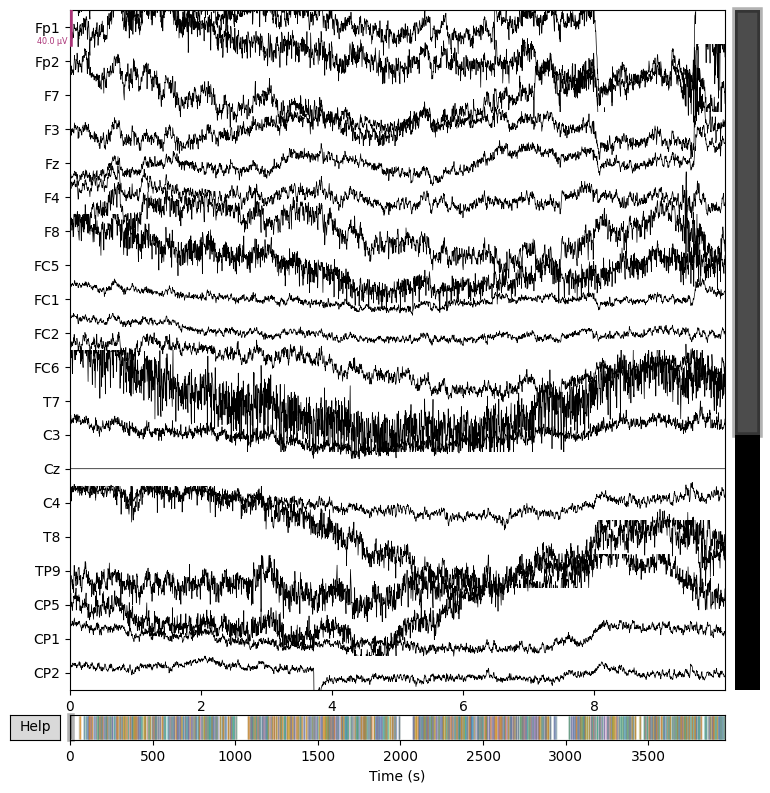

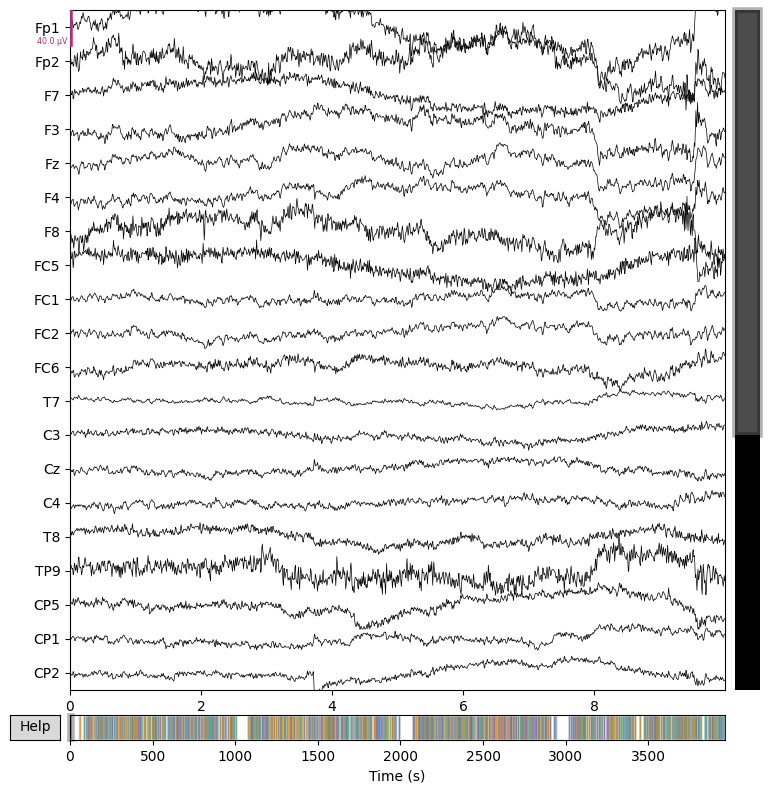

In [38]:
graph1=original_eeg['23'].plot()
graph2=final_copy.plot()

<h2> Flujo general </h2>

¡Ya está! Hemos terminado el primer tutorial, a grandes rasgos, podemos ver que hicimos lo siguiente:

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_06.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Flujo paso por paso.</figcaption>
</figure>




<br>


O, si lo queremos ver en fases, podemos también simplificarlo así:

<br>

<figure style="text-align:left; margin: 1.25rem 0;background:#fff;">
  <img src="https://raw.githubusercontent.com/neuropucp/neuroling-workshop/refs/heads/main/res/assets/status_05.png"
       alt="vol"
       style="display:block; margin:0 auto; max-width:50%; width:600px; height:auto;">
  <figcaption style="margin-top:.5rem; color:#555;">Flujo general.</figcaption>
</figure>



<h2>Código completo para ser ejecutado automáticamente a todos los participantes</h2>

Podemos ejecutar todos estos pasos de manera automática en una iteración con cada participante. Ya tenemos los diccionarios `train_eeg`, con los objetos filtrados para entrenar ICA, y `filtered_eeg` con los objetos con nuestros filtros finales.

In [ ]:
########################
#########ICA############
########################
#Creemos un diccionario para guardar los objetos eeg finales
cleaned_eeg={}
for sub, eeg in train_eeg.items(): #Iteramos en los datos de entrenamiento.
  rank_train_dictionary=mne.compute_rank(eeg)
  rank_train=rank_train_dictionary['eeg']

  ica = mne.preprocessing.ICA(
              n_components=rank_train, #Rank o dimensiones independientes.
              method = "infomax",  # Método
              fit_params = {'extended':True}, #Parámetros del método.
              max_iter = "auto",
              random_state = 7  # Lucky!
          )

  ica.fit(eeg, picks='eeg') #eeg es por default, pero es buena práctica.

  eog_indices, eog_scores = ica.find_bads_eog( #Este es el método.
    single_test_sub, #pasamos nuestro set de entrenamiento
    ch_name=['HEOG', 'VEOG'],
    threshold=3.0,
    verbose=False
  )

  ic_labels = mne_icalabel.label_components(
    single_test_sub,
    ica,
    method="iclabel"
    )

  labels = ic_labels["labels"] #obtenemos las "labels" o descripciones de los componentes.
  probs = ic_labels["y_pred_proba"] #obtenemos las probabilidades de cada label.
  exclude_idx = [
      idx for idx, (label, prob) in enumerate(zip(labels, probs))
      if label not in ["brain", "other"] and prob > 0.9 #seleccionamos las labels, y solamente las agregamos si tienen una probabilidad de 0.9
      ]

  ica.exclude=list(set(ica.exclude + eog_indices)) #No reemplacemos una lista con otra. Combinémoslas.

  #Podemos guardar los objetos si los necesitamos para luego
  path=os.path.join(os.getcwd(), f'ica_objects/{sub}')
  os.makedirs(path, exist_ok=True)
  ica.save(os.path.join(path, f'{sub}_ica.fif'), overwrite=True)

  #Obtenemos la información de los objetos a aplicar
  eeg_to_apply=filtered_eeg[sub].copy()
  eeg_to_apply=eeg_to_apply.set_eeg_reference('average')
  rank_final_dictionary=mne.compute_rank(eeg_to_apply)
  rank_final=rank_final_dictionary['eeg']

  #Aplicamos la solución ICA
  eeg_final=ica.apply(
      eeg_to_apply,
      exclude=ica.exclude,
      n_pca_components=rank_final
  )
  #Guardamos los objetos finales en el diccionario
  cleaned_eeg[sub] = eeg_final



Referencias:


> - Gorgolewski, K. J., Auer, T., Calhoun, V. D., Craddock, R. C., Das, S., Duff, E. P., ... & Poldrack, R. A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific data, 3(1), 1-9.

> - Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.

> - Gramfort, A., Luessi, M., Larson, E., Engemann, D. A., Strohmeier, D., Brodbeck, C., ... & Hämäläinen, M. (2013). MEG and EEG data analysis with MNE-Python. Frontiers in Neuroinformatics, 7, 267.
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.17345411.svg)](https://doi.org/10.5281/zenodo.17345411).

>- Isasi-Isasmendi, A., Sauppe, S., Andrews, C., Laka, I., Meyer, M., & Bickel, B. (2024). Incremental sentence processing is guided by a preference for agents: EEG evidence from Basque. Language, Cognition and Neuroscience, 39(1), 76-97.

> - Jas, M., Engemann, D. A., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429.

> - Jas, M., Engemann, D., Raimondo, F., Bekhti, Y., & Gramfort, A. (2016, June). Automated rejection and repair of bad trials in MEG/EEG. In 2016 international workshop on pattern recognition in neuroimaging (PRNI) (pp. 1-4). IEEE.

> - Appelhoff, S., Hurst, A. J., Lawrence, A., Li, A., Mantilla Ramos, Y. J., O'Reilly, C., ... & Dancker, J. (2022). PyPREP: A Python implementation of the preprocessing pipeline (PREP) for EEG data. Zenodo, 2. [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.16039994.svg)](https://doi.org/10.5281/zenodo.16039994)

> - Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K.-M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in Neuroinformatics, 9, 16. doi: 10.3389/fninf.2015.00016

> - Mendoza-Halliday, D., Major, A. J., Lee, N., Lichtenfeld, M. J., Carlson, B., Mitchell, B., ... & Bastos, A. M. (2024). A ubiquitous spectrolaminar motif of local field potential power across the primate cortex. Nature Neuroscience, 27(3), 547-560.

> - Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896

> - Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G., Phillips, C., Delorme, A., & Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6(1), 103.

> - Newman, A. J. Neural data science in python (2020). URL https://neuraldatascience.io/intro.html.

> - Li, A., Feitelberg, J., Saini, A. P., Höchenberger, R., & Scheltienne, M. (2022). MNE-ICALabel: Automatically annotating ICA components with ICLabel in Python. Journal of Open Source Software, 7(76), 4484.

> - Pion-Tonachini, L., Kreutz-Delgado, K., & Makeig, S. (2019). ICLabel: An automated electroencephalographic independent component classifier, dataset, and website. NeuroImage, 198, 181-197.

> - Winkler, I., Debener, S., Müller, K. R., & Tangermann, M. (2015, August). On the influence of high-pass filtering on ICA-based artifact reduction in EEG-ERP. In 2015 37th annual international conference of the IEEE engineering in medicine and biology society (EMBC) (pp. 4101-4105). IEEE.



Autores:

Daniel Falcón.  
Renato Paredes.